In [247]:
%run -i ../header.py

In [178]:
import matplotlib.patches

In [3]:
data_pack = {
      "b": ["b-trans.deng2017-"+num for num in ("III", "IV", "V", "VI")]
    , "c": ["c-trans.deng2016-"+num for num in ("V", "VI", "VII", "VIII", "IX")]
}

# Export

In [4]:
def getPDGTrans(name):
    # return widths in [KeV]
    pdg_trans = pd.read_csv("../data/{}-trans.PDG.csv".format(name), header=0, index_col=[0,1], comment="#")["frac_width"]
    pdg_trans_err = pd.read_csv("../data/{}-trans.PDG.err.csv".format(name), header=0, index_col=[0,1], comment="#")["frac_width"]
    
    pdg_tot = pd.read_csv("../data/{}-widths.csv".format(name), header=0, index_col=0, comment="#")["PDG"]
    pdg_tot_spec = readSpec("../data/{}-widths.csv".format(name))
    pdg_tot_err = pd.read_csv("../data/{}-widths.err.csv".format(name), header=0, index_col=0, comment="#")["PDG"].abs()
    
    pdg_err = pdg_trans_err.copy()
    
    for instate in pdg_trans.index.levels[0]:
        pdg_err.loc[(instate, slice(None))] = (  pdg_trans_err[(instate, slice(None))].values*pdg_tot[instate]\
                                               + pdg_trans[(instate, slice(None))].values*pdg_tot_err[instate]\
                                              )*dimTrans(pdg_tot_spec["PDG"]["tags"][0], "KeV") # pdg[MeV] -> [KeV]
        pdg_trans.loc[(instate, slice(None))] = pdg_trans[(instate, slice(None))].values*pdg_tot[instate]*dimTrans(pdg_tot_spec["PDG"]["tags"][0], "KeV") # pdg[MeV] -> [KeV]
    
    pdg_trans.index = pd.Index([tuple("${}$".format(code2name(e)) for e in pair) for pair in pdg_trans.index.values], name=["In", "Out"])
    pdg_trans.rename("PDG", inplace=True)
    
    pdg_err.index = pd.Index([tuple("${}$".format(code2name(e)) for e in pair) for pair in pdg_trans_err.index.values], name=["In", "Out"])
    pdg_err = pdg_err.reindex(pdg_trans.index)
    
    return pdg_trans, pdg_err

In [5]:
def getDengTrans(prefix, cfgname):
    # return trans widths of Deng in KeV
    prefixToCol = {"scr": "SP", "lin": "LP"}
    
    col = prefixToCol[prefix]
    spec = readSpec("../data/{}.csv".format(cfgname))
    deng = pd.read_csv("../data/{}.csv".format(cfgname), header=0, index_col=[0,1], comment="#")
    for k, v in spec.items():
        deng[k] *= dimTrans(v["tags"][0], "KeV")
    deng.rename(columns={col: "Deng"}, inplace=True)
    deng.index = pd.Index([tuple("${}$".format(code2name(e)) for e in pair) for pair in deng.index.values], name=["In", "Out"])
    return deng

In [6]:
def getRs(particle, prefix, cfgname, suffix=""):
    # return my widths in KeV
    data = pd.read_csv("output/{}.{}/widths{}".format(prefix, cfgname, suffix), header=0, index_col = [0, 1], comment="#")
    data *= dimTrans("GeV", "KeV")
    data = data.loc[(data != 0).any(axis=1), :]
    data["in0"] /= data["width"]
    data["in2"] /= data["width"]
    data["out0"] /= data["width"]
    data["out2"] /= data["width"]
    data.index.names = ["In", "Out"]
    
    data_sub = data.query("In == '{0}'".format(particle))\
        .rename(columns={"out0": "$r^{(0)}$", "out2": "$r^{(2)}$"})\
        .drop(columns=["in0", "in2"])
    data_above = data.query("Out == '{0}'".format(particle))\
        .rename(columns={"in0": "$r^{(0)}$", "in2": "$r^{(2)}$"})\
        .drop(columns=["out0", "out2"])
    
    data = pd.concat([data_sub, data_above])
    data.columns = ["$\Gamma$", "$r^{(0)}$", "$r^{(2)}$"]
    
    data.index = pd.Index([tuple("${}$".format(code2name(e)) for e in pair) for pair in data.index.values], name=["In", "Out"])
    return data

In [7]:
def reportRs(pname, prefix, cfgname, suffixes=["", "E1"]): # allowed suffixes: "", "E1", "ELW"
    stack = []
    deng_stack = []
    parts = [getRs(pname, prefix, cfgname, suffix)\
                                .add_prefix("" if suffix == "" else suffix+"-")\
                            for suffix in suffixes]
    parts = [part for part in parts if not part.empty]
    if len(parts) > 0:
        stack.append(pd.concat(parts, axis=1))
    
    for dataf in data_pack[cfgname.split("-")[0]]:
        deng_stack.append(getDengTrans(prefix, dataf)["Deng"])
    
    stack = pd.concat(stack, sort=False)
    deng_stack = pd.concat(deng_stack, axis=0, sort=False).reindex(stack.index.values)
    pdg, _ = getPDGTrans(cfgname.split("-")[0])
    pdg = pdg.reindex(stack.index.values)
    
    res = pd.concat([pdg, deng_stack, stack], sort=False, axis=1)
    res = dfsort(res, lambda a,b: cmpMultyStatesByCode(prefix, cfgname
                                                      ,[name2code(i[1:-1]) for i in a]
                                                      ,[name2code(i[1:-1]) for i in b]))
    return res

## Widths

### $\psi(1S)$ and $\Upsilon(1S)$

In [7]:
for suff in [["", "E1"], ["E1", "ELW"]]:
    print(suff)
    res = reportRs("psi_1S", "scr", "c-scr", suffixes=suff)
    display(res)
    with open("export/width{}.psi_1S.c-scr.tex".format("-".join(suff)), "w") as f:
        f.write(res.to_latex(escape=False, bold_rows=True, column_format="l|l|r|r|r|r|r|r|r|r"))

['', 'E1']


,,PDG,Deng,$\Gamma$,$r^{(0)}$,$r^{(2)}$,E1-$\Gamma$,E1-$r^{(0)}$,E1-$r^{(2)}$
In,Out,,,,,,,,
$\psi(1S)$,$\eta_{c}(1S)$,1.58,2.44,2.79,1,0,nan,nan,nan
$\chi_{c0}(1P)$,$\psi(1S)$,151,179,142,1,0,142,1,0
$\chi_{c1}(1P)$,$\psi(1S)$,288,319,310,0.569,0,309,0.5,0
$\chi_{c2}(1P)$,$\psi(1S)$,374,292,510,0.143,0.519,506,0.1,0.6
$\eta_{c}(2S)$,$\psi(1S)$,nan,2.29,2.91,1,0,nan,nan,nan
$\chi_{c0}(2P)$,$\psi(1S)$,nan,2.3,1.89,1,0,1.89,1,0
$\chi_{c1}(2P)$,$\psi(1S)$,nan,88,74.4,0.623,0,73.3,0.5,0
$\chi_{c2}(2P)$,$\psi(1S)$,nan,93,237,0.17,0.471,233,0.1,0.6


['E1', 'ELW']


,,PDG,Deng,E1-$\Gamma$,E1-$r^{(0)}$,E1-$r^{(2)}$,ELW-$\Gamma$,ELW-$r^{(0)}$,ELW-$r^{(2)}$
In,Out,,,,,,,,
$\chi_{c0}(1P)$,$\psi(1S)$,151,179,142,1,0,183,1,0
$\chi_{c1}(1P)$,$\psi(1S)$,288,319,309,0.5,0,382,0.5,0
$\chi_{c2}(1P)$,$\psi(1S)$,374,292,506,0.1,0.6,490,0.1,0.6
$\chi_{c0}(2P)$,$\psi(1S)$,nan,2.3,1.89,1,0,3.3,1,0
$\chi_{c1}(2P)$,$\psi(1S)$,nan,88,73.3,0.5,0,51.9,0.5,0
$\chi_{c2}(2P)$,$\psi(1S)$,nan,93,233,0.1,0.6,132,0.1,0.6


In [8]:
for suff in [["", "E1"], ["E1", "ELW"]]:
    print(suff)
    res = reportRs("psi_1S", "lin", "c-lin", suffixes=suff)
    display(res)
    with open("export/width{}.psi_1S.c-lin.tex".format("-".join(suff)), "w") as f:
        f.write(res.to_latex(escape=False, bold_rows=True, column_format="l|l|r|r|r|r|r|r|r|r"))

['', 'E1']


,,PDG,Deng,$\Gamma$,$r^{(0)}$,$r^{(2)}$,E1-$\Gamma$,E1-$r^{(0)}$,E1-$r^{(2)}$
In,Out,,,,,,,,
$\psi(1S)$,$\eta_{c}(1S)$,1.58,2.39,2.53,1,0,nan,nan,nan
$\chi_{c0}(1P)$,$\psi(1S)$,151,172,138,1,0,138,1,0
$\chi_{c1}(1P)$,$\psi(1S)$,288,306,301,0.566,0,300,0.5,0
$\chi_{c2}(1P)$,$\psi(1S)$,374,284,490,0.141,0.523,486,0.1,0.6
$\eta_{c}(2S)$,$\psi(1S)$,nan,2.64,3.04,1,0,nan,nan,nan
$\chi_{c0}(2P)$,$\psi(1S)$,nan,6.1,2.66,1,0,2.66,1,0
$\chi_{c1}(2P)$,$\psi(1S)$,nan,81,69.1,0.616,0,68.2,0.5,0
$\chi_{c2}(2P)$,$\psi(1S)$,nan,93,231,0.166,0.477,227,0.1,0.6


['E1', 'ELW']


,,PDG,Deng,E1-$\Gamma$,E1-$r^{(0)}$,E1-$r^{(2)}$,ELW-$\Gamma$,ELW-$r^{(0)}$,ELW-$r^{(2)}$
In,Out,,,,,,,,
$\chi_{c0}(1P)$,$\psi(1S)$,151,172,138,1,0,177,1,0
$\chi_{c1}(1P)$,$\psi(1S)$,288,306,300,0.5,0,367,0.5,0
$\chi_{c2}(1P)$,$\psi(1S)$,374,284,486,0.1,0.6,471,0.1,0.6
$\chi_{c0}(2P)$,$\psi(1S)$,nan,6.1,2.66,1,0,1.66,1,0
$\chi_{c1}(2P)$,$\psi(1S)$,nan,81,68.2,0.5,0,46.4,0.5,0
$\chi_{c2}(2P)$,$\psi(1S)$,nan,93,227,0.1,0.6,129,0.1,0.6


In [ ]:
for suff in [["", "E1"], ["E1", "ELW"]]:
    print(suff)
    res = reportRs("yps_1S", "scr", "b-scr", suffixes=suff)
    display(res)
    with open("export/width{}.yps_1S.b-scr.tex".format("-".join(suff)), "w") as f:
        f.write(res.to_latex(escape=False, bold_rows=True, column_format="l|l|r|r|r|r|r|r|r|r"))

### $\psi(2S)$ and $\Upsilon(2S)$

In [ ]:
for suff in [["", "E1"], ["E1", "ELW"]]:
    print(suff)
    res = reportRs("psi_2S", "scr", "c-scr", suffixes=suff)
    display(res)
    with open("export/width{}.psi_2S.c-scr.tex".format("-".join(suff)), "w") as f:
        f.write(res.to_latex(escape=False, bold_rows=True, column_format="l|l|r|r|r|r|r|r|r|r"))

In [ ]:
for suff in [["", "E1"], ["E1", "ELW"]]:
    print(suff)
    res = reportRs("psi_2S", "lin", "c-lin", suffixes=suff)
    display(res)
    with open("export/width{}.psi_2S.c-lin.tex".format("-".join(suff)), "w") as f:
        f.write(res.to_latex(escape=False, bold_rows=True, column_format="l|l|r|r|r|r|r|r|r|r"))

In [ ]:
for suff in [["", "E1"], ["E1", "ELW"]]:
    print(suff)
    res = reportRs("yps_2S", "scr", "b-scr", suffixes=suff)
    display(res)
    with open("export/width{}.yps_2S.b-scr.tex".format("-".join(suff)), "w") as f:
        f.write(res.to_latex(escape=False, bold_rows=True, column_format="l|l|r|r|r|r|r|r|r|r"))

### $\psi(3S)$ and $\Upsilon(3S)$

In [ ]:
for suff in [["", "E1"], ["E1", "ELW"]]:
    print(suff)
    res = reportRs("psi_3S", "scr", "c-scr", suffixes=suff)
    display(res)
    with open("export/width{}.psi_3S.c-scr.tex".format("-".join(suff)), "w") as f:
        f.write(res.to_latex(escape=False, bold_rows=True, column_format="l|l|r|r|r|r|r|r|r|r"))

In [ ]:
for suff in [["", "E1"], ["E1", "ELW"]]:
    print(suff)
    res = reportRs("psi_3S", "lin", "c-lin", suffixes=suff)
    display(res)
    with open("export/width{}.psi_3S.c-lin.tex".format("-".join(suff)), "w") as f:
        f.write(res.to_latex(escape=False, bold_rows=True, column_format="l|l|r|r|r|r|r|r|r|r"))

In [ ]:
for suff in [["", "E1"], ["E1", "ELW"]]:
    print(suff)
    res = reportRs("yps_3S", "scr", "b-scr", suffixes=suff)
    display(res)
    with open("export/width{}.yps_3S.b-scr.tex".format("-".join(suff)), "w") as f:
        f.write(res.to_latex(escape=False, bold_rows=True, column_format="l|l|r|r|r|r|r|r|r|r"))

### $\psi_1(1D)$ which is $\psi(3770)$

In [ ]:
for suff in [["", "E1"], ["E1", "ELW"]]:
    print(suff)
    res = reportRs("psi_1_1D", "scr", "c-scr", suffixes=suff)
    display(res)
    with open("export/width{}.psi_1_1D.c-scr.tex".format("-".join(suff)), "w") as f:
        f.write(res.to_latex(escape=False, bold_rows=True, column_format="l|l|r|r|r|r|r|r|r|r"))

In [ ]:
for suff in [["", "E1"], ["E1", "ELW"]]:
    print(suff)
    res = reportRs("psi_1_1D", "lin", "c-lin", suffixes=suff)
    display(res)
    with open("export/width{}.psi_1_1D.c-lin.tex".format("-".join(suff)), "w") as f:
        f.write(res.to_latex(escape=False, bold_rows=True, column_format="l|l|r|r|r|r|r|r|r|r"))

## Sumrules for the thesis

In [8]:
def getMasses(prefix, cfgname):
    # return masses in MeV
    with open("../quarkEigen/output/{}.{}/config".format(prefix, cfgname), "r") as f:
        mass_cfg = json.load(f, object_pairs_hook=OrderedDict)
    with open("../quarkEigen/output/{}.{}/exclude".format(prefix, cfgname), "r") as f:
        mass_excl = f.read().split("\n")
    mass_data = OrderedDict()
    for particle, pdata in mass_cfg.items():
        if particle not in mass_excl:
            continue
        energ_data = pd.read_csv("../quarkEigen/output/{}.{}/data/{}/minE.dat".format(prefix, cfgname, particle))\
                     .iloc[-1, 1]
        energ = pdata["eq"]["env"]["mC"]*2 + energ_data
        mass_data.update({particle: energ})
    mass_data = pd.DataFrame.from_dict(mass_data, orient="index")
    mass_data.columns = ["E"]
    mass_data["E"] *= dimTrans("GeV", "MeV")
    pdg_spec = readSpec("../data/{}-spectrum.csv".format(cfgname.split("-")[0]))["PDG"]
    pdg = pd.read_csv("../data/{}-spectrum.csv".format(cfgname.split("-")[0]), header=0, index_col=0, comment="#")["PDG"]\
        *dimTrans(pdg_spec["tags"][0], "MeV")
    pdg = pdg.loc[pdg.index.intersection(mass_data.index).values]
    
    pdg_err_spec = readSpec("../data/{}-spectrum.err.csv".format(cfgname.split("-")[0]))["PDG"]
    pdg_err = pd.read_csv( "../data/{}-spectrum.err.csv".format(cfgname.split("-")[0]) \
                          , header=0\
                          , index_col=0\
                          , comment="#")["PDG"] * dimTrans(pdg_err_spec["tags"][0], "MeV")
    pdg_err = pdg_err.loc[pdg_err.index.intersection(pdg.index).values]
    
    mass_data["Emix"] = mass_data[["E"]]
    mass_data.loc[~pd.isna(pdg), "Emix"] = pdg.loc[~pd.isna(pdg)]
    mass_data["PDG"] = pdg
    
    mass_data_err = mass_data*sp.nan
    mass_data_err["PDG"] = pdg_err
    mass_data_err.loc[~pd.isna(pdg), "Emix"] = pdg_err.loc[~pd.isna(pdg)]
    
    mass_data.index = pd.Index(["${}$".format(code2name(k)) for k in mass_data.index.values], name="States")
    mass_data_err.index = mass_data.index.copy()
    
    return mass_data, mass_data_err.abs()

In [9]:
def getPprops(prefix, cfgname):
    with open("../quarkEigen/output/{}.{}/config".format(prefix, cfgname), "r") as f:
        pprops = json.load(f, object_pairs_hook=OrderedDict)
    props = pd.DataFrame(OrderedDict([(particle, values["eq"]) for particle, values in pprops.items()])).T
    props.drop(columns=["env", "E"], inplace=True)
    props.index = pd.Index([r"${}$".format(code2name(particle)) for particle in pprops.keys()], name="States")
    props = props.apply(pd.to_numeric, axis=0)
    return props

In [10]:
def getSumrule(pname, prefix, cfgname, suffix=""):
    msuffix = "" if suffix == "" else suffix+"-" 
    pretty_pname = "${}$".format(code2name(pname))
    
    widths = reportRs(pname, prefix, cfgname, [suffix])
    masses = getMasses(prefix, cfgname)[0][["Emix"]].rename(columns={"Emix": "E"})
    pprops = getPprops(prefix, cfgname)
    
    sumrule = []

    abovethr = [p[0] for p in widths.query("Out == r'{}'".format(pretty_pname)).index.values]
    sumrule.append(
        8*sp.pi**2*masses.loc[abovethr, "E"]**3\
        /(masses.loc[abovethr, "E"]**2 - masses.loc[pretty_pname, "E"]**2)**3\
        *pprops.loc[abovethr, "xJ"]
    )
    sumrule[0].index = pd.Index([(v, pretty_pname) for v in sumrule[0].index.values])
    
    belowthr = [p[1] for p in widths.query("In == r'{}'".format(pretty_pname)).index.values]
    sumrule.append(
        8*sp.pi**2*masses.loc[pretty_pname, "E"]**3\
        /(masses.loc[pretty_pname, "E"]**2 - masses.loc[belowthr, "E"]**2)**3\
        *pprops.loc[pretty_pname, "xJ"]
    )
    sumrule[1].index = pd.Index([(pretty_pname, v) for v in sumrule[1].index.values])
    sr = pd.concat(sumrule)*(0.19732697)**2*10**4*10**3
    sr = sr.reindex(widths.index.values)
    
    widths["$SR-PDG$"] = widths["PDG"].values
    if sp.any(pd.isna(widths["PDG"])):
        widths.loc[pd.isna(widths["PDG"]), "$SR-PDG$"] = widths.loc[pd.isna(widths["PDG"]).index.values, msuffix+"$\Gamma$"]
    widths.loc[:, "$SR-PDG$"] *= sr*(widths.loc[:, msuffix+"$r^{(2)}$"] - widths.loc[:, msuffix+"$r^{(0)}$"])
    
    widths["$SR-Deng$"] = widths["Deng"]
    if sp.any(pd.isna(widths["Deng"])):
        widths.loc[pd.isna(widths["Deng"]), "$SR-Deng$"] = widths.loc[pd.isna(widths["Deng"]).index.values, msuffix+"$\Gamma$"]
    widths.loc[:, "$SR-Deng$"] *= sr*(widths.loc[:, msuffix+"$r^{(2)}$"] - widths.loc[:, msuffix+"$r^{(0)}$"])
    
    widths["$SR-\Gamma$"] = widths[msuffix+"$\Gamma$"]*sr*(widths.loc[:, msuffix+"$r^{(2)}$"] - widths.loc[:, msuffix+"$r^{(0)}$"])
    
    widths.drop(columns=[msuffix+'$r^{(2)}$', msuffix+'$r^{(0)}$'], inplace=True)
    widths = widths[[widths.columns[i] for i in [0, 3, 1, 4, 2, 5]]]
    widths = dfsort(widths, lambda a,b: cmpMultyStatesByCode(prefix, cfgname
                                                         ,[name2code(i[1:-1]) for i in a]
                                                         ,[name2code(i[1:-1]) for i in b]))
    
    sigma = (widths["$SR-Deng$"] - widths["$SR-\Gamma$"]).std()
    
    return widths, pd.DataFrame(widths[["$SR-PDG$", "$SR-Deng$", "$SR-\Gamma$"]].sum().rename("$SR$")), sigma

In [11]:
def reportSumrules(pname, prefix, cfgname, suffixes=("", "E1", "ELW"), sigma=0):
    if sigma is not None:
        try:
            sigma = list(sigma)
        except TypeError:
            sigma = [sigma]*len(suffixes)
        sigma = dict(zip(suffixes, sigma))
    for approx in suffixes:
        report, sr, autosigma = getSumrule(pname, prefix, cfgname, approx)
        sigma[approx] = autosigma if sigma[approx] == 0 else sigma[approx]
        
        tab = Tabular("|l|l|c|c|c|c|c|c|")
        
        # Header
        tab.add_hline()
        tab.add_row(["", ""] + [NoEscape(i) for i in report.columns])
        tab.add_row([NoEscape(i) for i in report.index.names] + [""]*6)
        tab.add_hline()
        
        curN = "1"
        tot = report.iloc[0, 1::2].fillna(0)*0
        getN = re.compile("\((\d+)[A-Z]\)\$$")
        for entry in report.index.values:
            # Manage subtotals
            label = entry[0] if entry[0] != "${}$".format(code2name(pname)) else entry[1]
            newN = getN.search(label).groups()[0]
            if newN != curN:
                tab.add_hline()
                tab.add_hline()
                try:
                    tab.add_row([MultiColumn(2, align="|c|", data="Subtotal")] +\
                            [MultiColumn(2, align="|r|", data=NoEscape("${:.2f} ({:.2f}\sigma)$".format(num, num/sigma[approx]))) for num in tot])
                except:
                    tab.add_row([MultiColumn(2, align="|c|", data="Subtotal")] +\
                            [MultiColumn(2, align="|r|", data="{:.2f}".format(num)) for num in tot])                
                tab.add_hline()
                tab.add_hline()
                tot = report.loc[entry].fillna(0).values[1::2]
                curN = newN
            else:
                tot += report.loc[entry].fillna(0).values[1::2]
            
            # Regular entry
            tab.add_row([NoEscape(i) for i in list(entry) + ["{:.2f}".format(num) for num in report.loc[entry]]])
            
        # Final subtotal
        tab.add_hline()
        tab.add_hline()
        try:
            tab.add_row([MultiColumn(2, align="|c|", data="Subtotal")] +\
                    [MultiColumn(2, align="|r|", data=NoEscape("${:.2f}~({:.2f}\sigma)$".format(num, num/sigma[approx]))) for num in tot])
        except:
            tab.add_row([MultiColumn(2, align="|c|", data="Subtotal")] +\
                    [MultiColumn(2, align="|r|", data="{:.2f}".format(num)) for num in tot])                
        tab.add_hline()
        tab.add_hline()
        
        # Total
        try:
            tab.add_row([MultiColumn(2, align="|c|", data="Total")] +\
                    [MultiColumn(2, align="|r|", data=NoEscape("${:.2f}~({:.2f}\sigma)$".format(num, num/sigma[approx]))) for num in sr.iloc[:, 0]])
        except:
            tab.add_row([MultiColumn(2, align="|c|", data="Total")] +\
                    [MultiColumn(2, align="|r|", data="{:.2f}".format(num)) for num in sr.iloc[:, 0]])                
        tab.add_hline()
        
        # with open("export/sr{}.{}.{}.tex".format(approx, pname, cfgcode), "w") as f:
        #     f.write(sr.to_latex(escape=False, bold_rows=True, column_format="l|c"))
        # with open("export/sr{}-report.{}.{}.tex".format(approx, pname, cfgcode), "w") as f:
        #     f.write(report.to_latex(escape=False, bold_rows=True, column_format="l|l|c|c|c|c|c|c"))
        tab.generate_tex("export/sr{}-report.{}.{}".format(approx, pname, cfgname))

## Bottomonium sumrules

### $\Upsilon(1S)$

In [106]:
reportSumrules("yps_1S", "scr", "b-scr", sigma=[0]*3)

### $\Upsilon(2S)$

In [107]:
reportSumrules("yps_2S", "scr", "b-scr", sigma=[0]*3)

### $\Upsilon(3S)$

In [108]:
reportSumrules("yps_3S", "scr", "b-scr")

## Charmonium sumrules

### $\psi(1S)$

In [109]:
reportSumrules("psi_1S", "scr", "c-scr", sigma=6.7)

In [110]:
reportSumrules("psi_1S", "lin", "c-lin", sigma=6.7)

### $\psi(2S)$

In [111]:
reportSumrules("psi_2S", "scr", "c-scr", sigma=16.6)

In [112]:
reportSumrules("psi_2S", "lin", "c-lin", sigma=16.6)

### $\psi(3S)$

In [113]:
reportSumrules("psi_3S", "scr", "c-scr")

In [114]:
reportSumrules("psi_3S", "lin", "c-lin")

In [115]:
reportSumrules("psi_1_1D", "scr", "c-scr", sigma=[0]*3)

In [116]:
reportSumrules("psi_1_1D", "lin", "c-lin")

## Sumrules for the article

In [12]:
def getE1Widths(pname, prefix, cfgname):
    my_E1 = getRs(pname, prefix, cfgname, suffix="E1")
    my_E1.rename(columns={"$\Gamma$": "E1", "$r^{(0)}$": "r0", "$r^{(2)}$": "r2"}, inplace=True)
    deng = pd.concat([getDengTrans(prefix, cfg) for\
                          cfg in data_pack[cfgname.split("-")[0]]
                     ], sort=False, axis=0)
    pdg, pdg_err = getPDGTrans(cfgname.split("-")[0])
    pdg = pdg.reindex(my_E1.index)
    pdg_err = pdg_err.reindex(my_E1.index)
    deng = deng.drop(columns="Deng").reindex(my_E1.index.values)
    deng["E1_min"] = deng.join(my_E1[["E1"]]).min(axis=1)
    deng["E1_max"] = deng.join(my_E1[["E1"]]).max(axis=1)
    deng = deng[["E1_min", "E1_max"]]
    res = pd.concat([pdg, my_E1, deng], axis=1)
    err = res*sp.nan
    err["PDG"] = pdg_err
    return res, err.abs()

In [13]:
def getFullWidths(pname, prefix, cfgname):
    my = getRs(pname, prefix, cfgname, suffix="")
    my.rename(columns={"$\Gamma$": "Full", "$r^{(0)}$": "r0", "$r^{(2)}$": "r2"}, inplace=True)
    deng = pd.concat([getDengTrans(prefix, cfg) for\
                          cfg in data_pack[cfgname.split("-")[0]]
                     ], sort=False, axis=0)
    pdg, pdg_err = getPDGTrans(cfgname.split("-")[0])
    pdg = pdg.reindex(my.index)
    pdg_err = pdg_err.reindex(my.index)
    deng = deng[["Deng"]].reindex(my.index.values)
    res = pd.concat([pdg, my, deng], axis=1)
    err = res*sp.nan
    err["PDG"] = pdg_err
    return res, err.abs()

In [14]:
def getArtSumrule(pname, prefix, cfgname):
    pretty_pname = "${}$".format(code2name(pname))
    
    widths, widths_err = getE1Widths(pname, prefix, cfgname)
    masses = getMasses(prefix, cfgname)[0][["Emix"]].rename(columns={"Emix": "E"})
    pprops = getPprops(prefix, cfgname)
    
    sumrule_prefactors = []
    
    abovethr = widths.query("Out == r'{}'".format(pretty_pname))
    abovethr_pcls = [p[0] for p in abovethr.index.values]
    sumrule_prefactors.append(
        8*sp.pi**2*masses.loc[abovethr_pcls, "E"]**3\
        /(masses.loc[abovethr_pcls, "E"]**2 - masses.loc[pretty_pname, "E"]**2)**3\
        *pprops.loc[abovethr_pcls, "xJ"]
    )
    sumrule_prefactors[0].index = pd.Index([(v, pretty_pname) for v in sumrule_prefactors[0].index.values])
    
    belowthr = widths.query("In == r'{}'".format(pretty_pname))
    belowthr_pcls = [p[1] for p in belowthr.index.values]
    sumrule_prefactors.append(
        8*sp.pi**2*masses.loc[pretty_pname, "E"]**3\
        /(masses.loc[pretty_pname, "E"]**2 - masses.loc[belowthr_pcls, "E"]**2)**3\
        *pprops.loc[pretty_pname, "xJ"]
    )
    sumrule_prefactors[1].index = pd.Index([(pretty_pname, v) for v in sumrule_prefactors[1].index.values])
    
    sumrule_prefactors_cnct = pd.concat(sumrule_prefactors, axis=0)
    sumrule_prefactors_cnct = sumrule_prefactors_cnct.reindex(widths.index.values)
    
    sumrule_prefactors_cnct = sumrule_prefactors_cnct*(widths.loc[:, "r2"] - widths.loc[:, "r0"])\
                *(0.19732697)**2*10**4*10**3
    sumrule = widths.drop(columns=["r0", "r2"])\
                .apply(\
                        lambda s: s*sumrule_prefactors_cnct.values\
                    )
    sumrule_err = widths_err.drop(columns=["r0", "r2"])\
                .apply(\
                        lambda s: s*sumrule_prefactors_cnct.values\
                    )
    
    widths.drop(columns=["r2", "r0"], inplace=True)
    widths = dfsort(widths, lambda a,b: cmpMultyStatesByCode(prefix, cfgname
                                                         ,[name2code(i[1:-1]) for i in a]
                                                         ,[name2code(i[1:-1]) for i in b]))
    sumrule = sumrule.reindex(widths.index.values)
    sumrule_err = sumrule_err.reindex(widths.index.values) 
    
    return widths, widths_err.abs(), sumrule, sumrule_err.abs()

In [15]:
def artSumruleReport(pname, prefix, cfgname):
    pretty_pname = "${}$".format(code2name(pname))
    def istriv(val):
        return sp.isnan(val) or val == 0
    
    def numfmt(num):
        return "{: .5f}".format(num)
    
    def quartet(a, amin, amax, b, sign=2):
        if not istriv(b):
            prec = -int(sp.floor(sp.log10(b)))+sign-1 # precision for 2 sign figure of b
        else:
            prec = -int(sp.floor(sp.log10(sp.absolute(amax-amin))))+sign-1 # if b is triv => prec = 2 sign figures of amax-amin
        
        return prec, sp.around(sp.array([a, amin, amax, b]), decimals=prec)
    
    def quartet_str(a, amin, amax, b, sign=2, labels=True, force_prec=None):
        if force_prec is None:
            prec, (a, amin, amax, b) = quartet(a, amin, amax, b, sign=sign)
        else:
            prec = force_prec
            a, amin, amax, b = sp.around(sp.array([a, amin, amax, b]), decimals=prec)
        if prec > 0:
            patt = r"{{:.{:d}f}}".format(prec)
        else:
            patt = r"{:d}"
            a = int(a)
            amin = int(amin)
            amax = int(amax)
            b = int(b) if not istriv(b) else b
        model_label_patt = r"_{{model}}" if labels else ""
        exp_label_patt = r"_{{exp}}" if labels else ""
        spread_patt = "_{{-"+patt+model_label_patt+"}}^{{+"+patt+"}}" if (amin or amax) else ""
        respatt = "${{"+patt+"}}"+spread_patt+"$"
        if not istriv(b):
            respatt += r"$\pm{{"+patt+"}}"+exp_label_patt+"$"
            
        format_params = [a] \
                      + ([sp.absolute(amin), amax] if spread_patt else []) \
                      + ([b] if not istriv(b) else [])
        return respatt.format(*format_params)
    
    def doublet(a, b, sign=2):
        prec, (a, amin, amax, b) = quartet(a, 0, 0.1, b, sign=sign) 
        return prec, sp.array([a, b])
    
    def doublet_str(a, b, sign=2, labels=True, force_prec=None):
        if force_prec is None:
            prec, (a, b) = doublet(a, b, sign=sign)
        else:
            prec = force_prec
            a, b = sp.around(sp.array([a, b]), decimals=prec)
        if prec > 0:
            patt = r"{{:.{:d}f}}".format(prec)
        else:
            patt = r"{:d}"
            a = int(a)
            b = int(b) if not istriv(b) else b
        exp_label_patt = r"_{{exp}}" if labels else ""
        respatt = r"${{"+patt+"}}$"
        if not istriv(b):
            respatt += r"$\pm{{"+patt+"}}"+exp_label_patt+"$"
            
        format_params = [a] \
                      + ([b] if not istriv(b) else [])
        return respatt.format(a, b)
    
    def fillsubtot(row):
        oldpdg = row["PDG"]
        for source in row.index.values:
            if istriv(oldpdg):
                
                if not istriv(row[source]):
                    continue

                if istriv(row["E1"]):
                    row[source] = 0
                else:
                    row[source] = row["E1"]
            else:
                row[source] = row["PDG"]
        return row
    
    def spreads(triple):
        return (triple[0], min(triple)-triple[0], max(triple)-triple[0])
    
    def get_regular_row(label_pair, label, abovethr, force_prec=None):
        # Regular entry
        curdata = widths.loc[label_pair, :]
        
        srentry = sumrule.loc[label_pair]["PDG"]
        if istriv(srentry): # srentry here is experimental res
            srentry = quartet_str( *spreads(sumrule.loc[label_pair, ["E1", "E1_min", "E1_max"]])
                                 , sumrule_err.loc[label_pair, "PDG"], force_prec=force_prec)
        else:
            srentry = doublet_str(srentry, sumrule_err.loc[label_pair, "PDG"], force_prec=force_prec)
        
        dwentry = widths.loc[label_pair]["PDG"]
        if istriv(dwentry):
            dwentry = quartet_str( *spreads(widths.loc[label_pair, ["E1", "E1_min", "E1_max"]])
                                 , widths_err.loc[label_pair, "PDG"])
        else:
            dwentry = doublet_str(dwentry, widths_err.loc[label_pair, "PDG"])

        massentry = doublet_str(masses.loc[label, "Emix"], sp.nan) # NaN to hide error bars for masses
        
        arrow = r"${} \rightarrow \gamma {}$".format(label[1:-1], pretty_pname[1:-1])\
                    if abovethr else\
                r"${} \rightarrow \gamma {}$".format(pretty_pname[1:-1], label[1:-1])
        
        return [NoEscape(i) for i in [arrow, massentry, dwentry, srentry]]
    
    widths, widths_err, sumrule, sumrule_err = getArtSumrule(pname, prefix, cfgname)
    sumrule[["E1_min", "E1_max"]] = sumrule[["E1_min", "E1_max"]].apply(lambda row: sorted(row), axis=1, result_type="expand").rename(columns={0: "E1_min", 1: "E1_max"})
    masses, masses_err = getMasses(prefix, cfgname)
    
    tab = Tabularx("X|c|c|r", width_argument=NoEscape("\columnwidth"))

    # Header
    tab.add_row([  "Process"
                 , NoEscape(r"$m_X$ [$MeV$]")\
                 , NoEscape(r"$\Gamma$ [$KeV$]".format(code2name(pname)))\
                 , NoEscape(r"$SR_1$ [$\mu b$]")
                ])
    tab.add_hline()

    curN = "1"
    tot = sumrule.iloc[0].fillna(0)*0
    tot_err = sumrule_err.iloc[0].fillna(0)*0
    getN = re.compile("\((\d+)[A-Z]\)\$$")
    
    regular_stack = []
    
    for label_pair in sumrule.index.values:
        if label_pair[0] == pretty_pname:
            label = label_pair[1]
            abovethr = False
        elif label_pair[1] == pretty_pname:
            label = label_pair[0]
            abovethr = True
        else:
            continue

        # Manage subtotals
        newN = getN.search(label).groups()[0]
        if newN != curN:
            subtot_prec, _ = quartet( *spreads(tot[["PDG", "E1_min", "E1_max"]])
                                     , sp.sqrt(tot_err["PDG"]))
            while regular_stack:
                row_args = regular_stack[0]
                trans_row = get_regular_row(*row_args, force_prec=subtot_prec)
                tab.add_row(trans_row)
                del regular_stack[0]
            tab.add_hline()
            
            srentry = quartet_str( *spreads(tot[["PDG", "E1_min", "E1_max"]])
                                     , sp.sqrt(tot_err["PDG"]))
            
            tab.add_row([MultiColumn(1, align="l", data=NoEscape("Subtotal")), MultiColumn(3, align="r", data=NoEscape(srentry))])
            tab.add_hline()
            tot = fillsubtot(sumrule.loc[label_pair].copy())
            tot_err = fillsubtot(sumrule_err.loc[label_pair].copy()**2)
            curN = newN
        else:
            tot += fillsubtot(sumrule.loc[label_pair].copy())
            tot_err += fillsubtot(sumrule_err.loc[label_pair].copy()**2)
            
        regular_stack.append((label_pair, label, abovethr))

    # Final subtotal
    subtot_prec, _ = quartet( *spreads(tot[["PDG", "E1_min", "E1_max"]])
                             , sp.sqrt(tot_err["PDG"]))
    while regular_stack:
        row_args = regular_stack[0]
        trans_row = get_regular_row(*row_args, force_prec=subtot_prec)
        tab.add_row(trans_row)
        del regular_stack[0]
    tab.add_hline()
    
    srentry = quartet_str( *spreads(tot[["PDG", "E1_min", "E1_max"]])
                                     , sp.sqrt(tot_err["PDG"]))
    
    tab.add_row([MultiColumn(1, align="l", data=NoEscape("Subtotal")), MultiColumn(3, align="r", data=NoEscape(srentry))])
    tab.add_hline()
    tab.add_hline()

    # Total
    tot = sumrule.apply(fillsubtot, axis=1).sum(axis=0)
    tot_err = sumrule_err.apply(sp.square).sum(axis=0)
    
    srentry = quartet_str( *spreads(tot[["PDG", "E1_min", "E1_max"]])
                                     , sp.sqrt(tot_err["PDG"]))
    
    tab.add_row([MultiColumn(1, align="l", data=NoEscape("Total")), MultiColumn(3, align="r", data=NoEscape(srentry))])
    
    return tab

In [16]:
def doArtSumruleReport(pname, prefix, cfgname):
    artSumruleReport(pname, prefix, cfgname).generate_tex("export/sr-article.{}.{}".format(pname, cfgname))

### Bottomonium sumrules

In [17]:
doArtSumruleReport("yps_1S", "scr", "b-scr")

In [18]:
doArtSumruleReport("yps_2S", "scr", "b-scr")

In [19]:
doArtSumruleReport("yps_3S", "scr", "b-scr")

###  Charmonium Screened Sumrules

In [344]:
doArtSumruleReport("psi_1S", "scr", "c-scr")

In [345]:
doArtSumruleReport("psi_2S", "scr", "c-scr")

In [346]:
doArtSumruleReport("psi_1_1D", "scr", "c-scr")

### Charmonium Linear

In [347]:
doArtSumruleReport("psi_1S", "lin", "c-lin")

In [348]:
doArtSumruleReport("psi_2S", "lin", "c-lin")

In [349]:
doArtSumruleReport("psi_1_1D", "lin", "c-lin")

## Decay widths for article

In [30]:
def artWidthsReport(pname, prefix, cfgname):
    pretty_pname = "${}$".format(code2name(pname))
    def istriv(val):
        return sp.isnan(val) or val == 0
    
    def numfmt(num):
        return "{: .5f}".format(num)
    
    def quartet(a, amin, amax, b, sign=2):
        if not istriv(b):
            prec = -int(sp.floor(sp.log10(b)))+sign-1 # precision for 2 sign figure of b
        else:
            prec = -int(sp.floor(sp.log10(sp.absolute(amax-amin))))+sign-1 # if b is triv => prec = 2 sign figures of amax-amin
        
        return prec, sp.around(sp.array([a, amin, amax, b]), decimals=prec)
    
    def quartet_str(a, amin, amax, b, sign=2):
        prec, (a, amin, amax, b) = quartet(a, amin, amax, b, sign=sign)
        if prec > 0:
            patt = r"{{:.{:d}f}}".format(prec)
        else:
            patt = r"{:d}"
            a = int(a)
            amin = int(amin)
            amax = int(amax)
            b = int(b) if not istriv(b) else b
        respatt = "${{"+patt+"}}_{{-"+patt+"}}^{{+"+patt+"}}$"
        if not istriv(b):
            respatt += r"$\pm{{"+patt+"}}$"
        return respatt.format(a, sp.absolute(amin), amax, b)
    
    def doublet(a, b, sign=2):
        prec, (a, amin, amax, b) = quartet(a, 0, 0.1, b, sign=sign) 
        return prec, sp.array([a, b])
    
    def doublet_str(a, b, sign=2):
        prec, (a, b) = doublet(a, b, sign=sign)
        if prec > 0:
            patt = r"{{:.{:d}f}}".format(prec)
        else:
            patt = r"{:d}"
            a = int(a)
            b = int(b) if not istriv(b) else b
        respatt = r"${{"+patt+"}}$"
        if not istriv(b):
            respatt += r"$\pm{{"+patt+"}}$"
        return respatt.format(a, b)
    
    def spreads(triple):
        return (triple[0], min(triple)-triple[0], max(triple)-triple[0])
    
    widths, widths_err = getE1Widths(pname, prefix, cfgname)
    masses, masses_err = getMasses(prefix, cfgname)
    
    tab = Tabularx("X|c|c|c", width_argument=NoEscape("\columnwidth"))

    # Header
    tab.add_row([  NoEscape(r"$V = {}$".format(code2name(pname)))\
                 , NoEscape(r"$M^{exp}_{X}$ [$MeV$]")\
#                  , NoEscape(r"$M^{model}_{X}$ [$MeV$]")\
                 , NoEscape(r"$\Gamma^{exp}$ [$KeV$]")\
                 , NoEscape(r"$\Gamma^{model}$ [$KeV$]")\
                ])
    tab.add_hline()

    curN = ""
    getN = re.compile(r"\((\d+)[A-Z]\)\$$")
    for label_pair in widths.index.values:
        if label_pair[0] == pretty_pname:
            label = label_pair[1]
            abovethr = False
        elif label_pair[1] == pretty_pname:
            label = label_pair[0]
            abovethr = True
        else:
            continue
    
        # Regular entry
        curdata = widths.loc[label_pair, :]
        
        dwentry_exp = widths.loc[label_pair]["PDG"]
        if istriv(dwentry_exp):
            continue
            
        newN = getN.search(label).group(0)
        if newN != curN:
            if curN:
                tab.add_hline()
            curN = newN
        
        dwentry_exp = doublet_str(dwentry_exp, widths_err.loc[label_pair, "PDG"])
        dwentry_model = quartet_str(*spreads(widths.loc[label_pair, ["E1", "E1_min", "E1_max"]]), sp.nan)
        
        arrow = r"${} \rightarrow \gamma V$" if abovethr else r"$V \rightarrow \gamma{}$"
        arrow = arrow.format(label[1:-1])
        
        massentry_exp = doublet_str(masses.loc[label, "PDG"], masses_err.loc[label, "PDG"])
        massentry_model = doublet_str(masses.loc[label, "E"], masses_err.loc[label, "E"])

#         tab.add_row([NoEscape(i) for i in [label, massentry_exp, massentry_model, arrow, dwentry_exp, dwentry_model]])
        tab.add_row([NoEscape(i) for i in [arrow, massentry_exp, dwentry_exp, dwentry_model]])
    tab.add_hline()
    
    return tab

In [31]:
def doArtWidthsReport(pname, prefix, cfgname):
    artWidthsReport(pname, prefix, cfgname).generate_tex("export/widths-article.{}.{}".format(pname, cfgname))

### Bottomonium widths

In [32]:
doArtWidthsReport("yps_1S", "scr", "b-scr")

In [33]:
doArtWidthsReport("yps_2S", "scr", "b-scr")

In [34]:
doArtWidthsReport("yps_3S", "scr", "b-scr")

###  Charmonium Screened Widths

In [304]:
doArtWidthsReport("psi_1S", "scr", "c-scr")

In [305]:
doArtWidthsReport("psi_2S", "scr", "c-scr")

In [306]:
doArtWidthsReport("psi_1_1D", "scr", "c-scr")

### Charmonium Linear

In [307]:
doArtWidthsReport("psi_1S", "lin", "c-lin")

In [308]:
doArtWidthsReport("psi_2S", "lin", "c-lin")

In [309]:
doArtWidthsReport("psi_1_1D", "lin", "c-lin")

## Decay widths E1 model comparison plots

In [72]:
def getModelWidthsPerPname(pname, prefix, cfgname):
    pretty_pname = "${}$".format(code2name(pname))
    my_E1 = getRs(pname, prefix, cfgname, suffix="E1")
    deng = pd.concat([getDengTrans(prefix, cfg) for\
                          cfg in data_pack[cfgname.split("-")[0]]
                     ], sort=False, axis=0)
    pdg, pdg_err = getPDGTrans(cfgname.split("-")[0])
    pdg = pdg.reindex(my_E1.index).loc[pretty_pname]
    pdg_err = pdg_err.reindex(my_E1.index).loc[pretty_pname]
    deng = deng.drop(columns="Deng").reindex(my_E1.index.values).loc[pretty_pname]
    res = pd.concat([pdg, deng], axis=1)
    err = res*sp.nan
    err["PDG"] = pdg_err
    for col in tuple(res.columns):
        if res[col].isnull().values.all():
            del res[col]
            del err[col]
    return res, err.abs()

In [106]:
def getModelWidthsDistributionPerModel(pname, prefix, cfgname):
    widths, errs = getModelWidthsPerPname(pname, prefix, cfgname)
    normalized = widths.div(widths["PDG"], axis="index") - 1
    assert not normalized["PDG"].isnull().values.all()
    normalized.drop(columns=["PDG"], inplace=True)
    return normalized, errs.div(widths["PDG"], axis="index")

In [283]:
def doPlotWidthsDistributionPerModel(ax, pname, prefix, cfgname, final_state_filter=None):
    if final_state_filter is None:
        final_state_filter = []
        
    macrostep = 1
    miniframe = 0.7
    markers = ["o", "s", "x", "*", "x", "P"]
    colors = ["red", "orange", "blue", "violet", "brown", "green"]
    
    widths, err = getModelWidthsDistributionPerModel(pname, prefix, cfgname)
    
    keep_index = [idx_val for idx_val in widths.index.values if any(fval in idx_val for fval in final_state_filter)]
    widths = widths.reindex(keep_index)
    err = err.reindex(keep_index)
    
    batch_size = len(widths.index)
    ministep = miniframe/batch_size
    
    state_marker_map = {state: {"marker": markers[i], "color": colors[i]} for i, state in enumerate(widths.index.values)}
    
    y = []
    y_err = []
    x = []
    xtick_pos = []
    xtick_label = []
    
    macro = 1
    for model in widths.columns:
        mini = 0
        for state in widths.index.values:
            y_value = widths.loc[state, model]
            y_err_value = err.loc[state, "PDG"]
            x_value = macro*macrostep - miniframe/2 + ministep*(mini + 0.5)
            ax.errorbar(x_value, y_value, yerr=y_err_value, linestyle="", marker=state_marker_map[state]["marker"],
                         color=state_marker_map[state]["color"])
            mini += 1
        xtick_pos.append(macro)
        xtick_label.append(model)
        macro += 1
    ax.axhline(0, color="gray", linestyle="--")
    ax.set_ylabel(r"$\frac{\Gamma_{model} - \Gamma_{exp}}{\Gamma_{exp}}$")
    ax.set_xticks(xtick_pos)
    ax.set_xticklabels(xtick_label)
    ax.set_ylim([-0.8, 0.8])
    
    legend_patches = []
    for state, marker_setting in state_marker_map.items():
        patch = matplotlib.patches.Patch(color=marker_setting["color"], label=f'${code2name(pname)}$ $\\rightarrow$ {state}')
        legend_patches.append(patch)
    ax.legend(handles=legend_patches, bbox_to_anchor=(1, 1), loc="upper left")

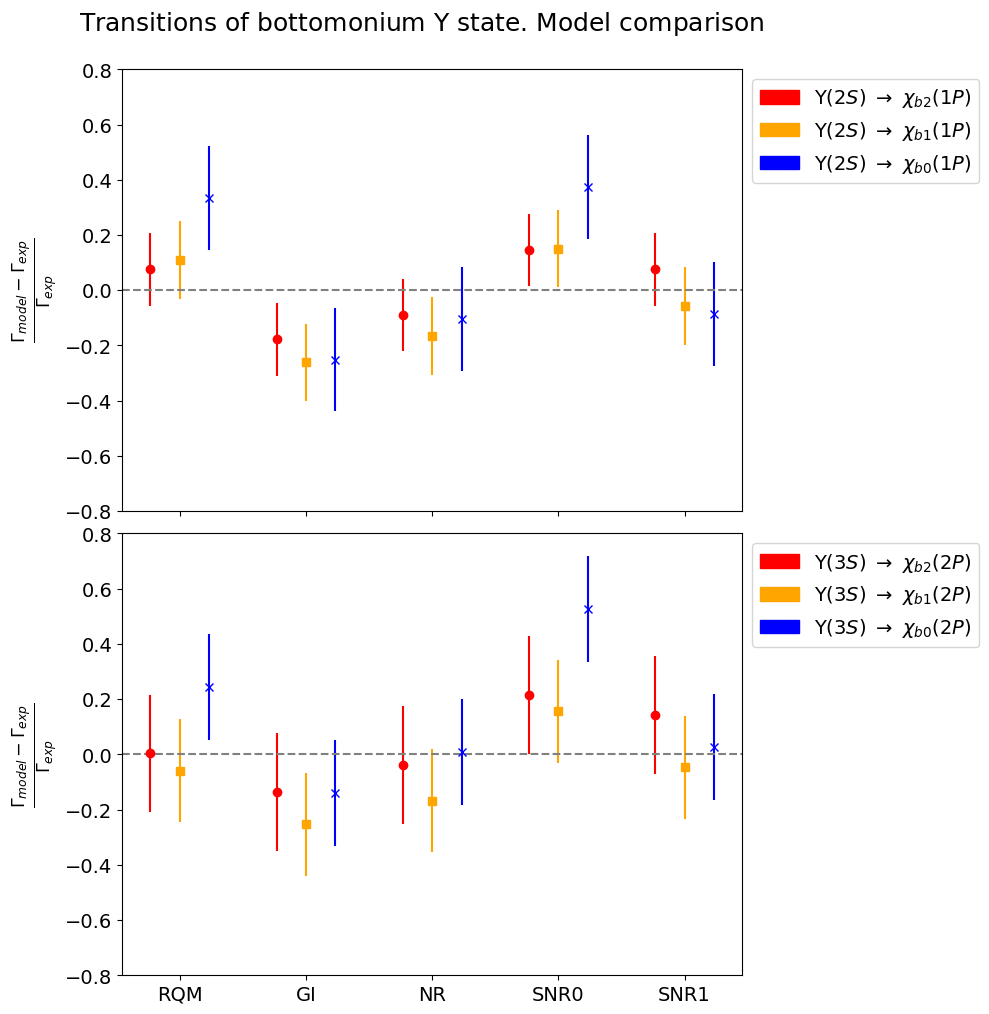

In [291]:
fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(FIG_HSIZE, 2*FIG_VSIZE), gridspec_kw={"hspace": 0.05})

fig.suptitle("Transitions of bottomonium $\\Upsilon$ state. Model comparison", y=0.93)
distribution_batch = [doPlotWidthsDistributionPerModel(axes[0], "yps_2S", "scr", "b-scr", final_state_filter=["1P"]),
                      doPlotWidthsDistributionPerModel(axes[1], "yps_3S", "scr", "b-scr", final_state_filter=["2P"])]

fig.savefig("export/widths_model_cmp-article.scr.b-scr.png", bbox_inches="tight")

In [279]:
raise KeyboardInterrupt("Enough for output")

KeyboardInterrupt: Enough for output